In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Retina mode
from latexify import latexify, format_axes
from MakeDataset import X_train, X_test, y_train, y_test

In [2]:
import warnings
# Suppressing all FutureWarnings and UserWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# Printing versions of libraries used
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,seaborn,scikit-learn,tsfel

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.19.0

numpy       : 1.26.2
pandas      : 2.2.0
matplotlib  : 3.8.2
seaborn     : 0.13.2
scikit-learn: 1.4.1.post1
tsfel       : 0.1.7



## Note:
#### Activity labels
1 WALKING <br>
2 WALKING_UPSTAIRS <br>
3 WALKING_DOWNSTAIRS <br>
4 SITTING <br>
5 STANDING <br>
6 LAYING <br>

# Question 1
### Use Sklearn Library to train Decision Tress. [1.5 marks]
- #### Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print()
    print("Confusion Matrix:")

    latexify(fig_width=8)
    activity_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_names)
    cm_display.plot(values_format='d', cmap='Blues', ax=plt.gca())
    plt.xticks(rotation=90)
    plt.show()

In [5]:
# First, we need to flatten the 3D time series data into a 2D array where each sample becomes a single vector. 
def flatten_data(data):
    flattened_data = data.reshape(data.shape[0], -1)
    return flattened_data

In [6]:
X_train_flat = flatten_data(X_train)
X_test_flat = flatten_data(X_test)
print("Shape of X_train_flat is", X_train_flat.shape)
print("Shape of X_test_flat is", X_test_flat.shape)

Shape of X_train_flat is (126, 1500)
Shape of X_test_flat is (54, 1500)


Accuracy: 0.61
Precision: 0.56
Recall: 0.61

Confusion Matrix:


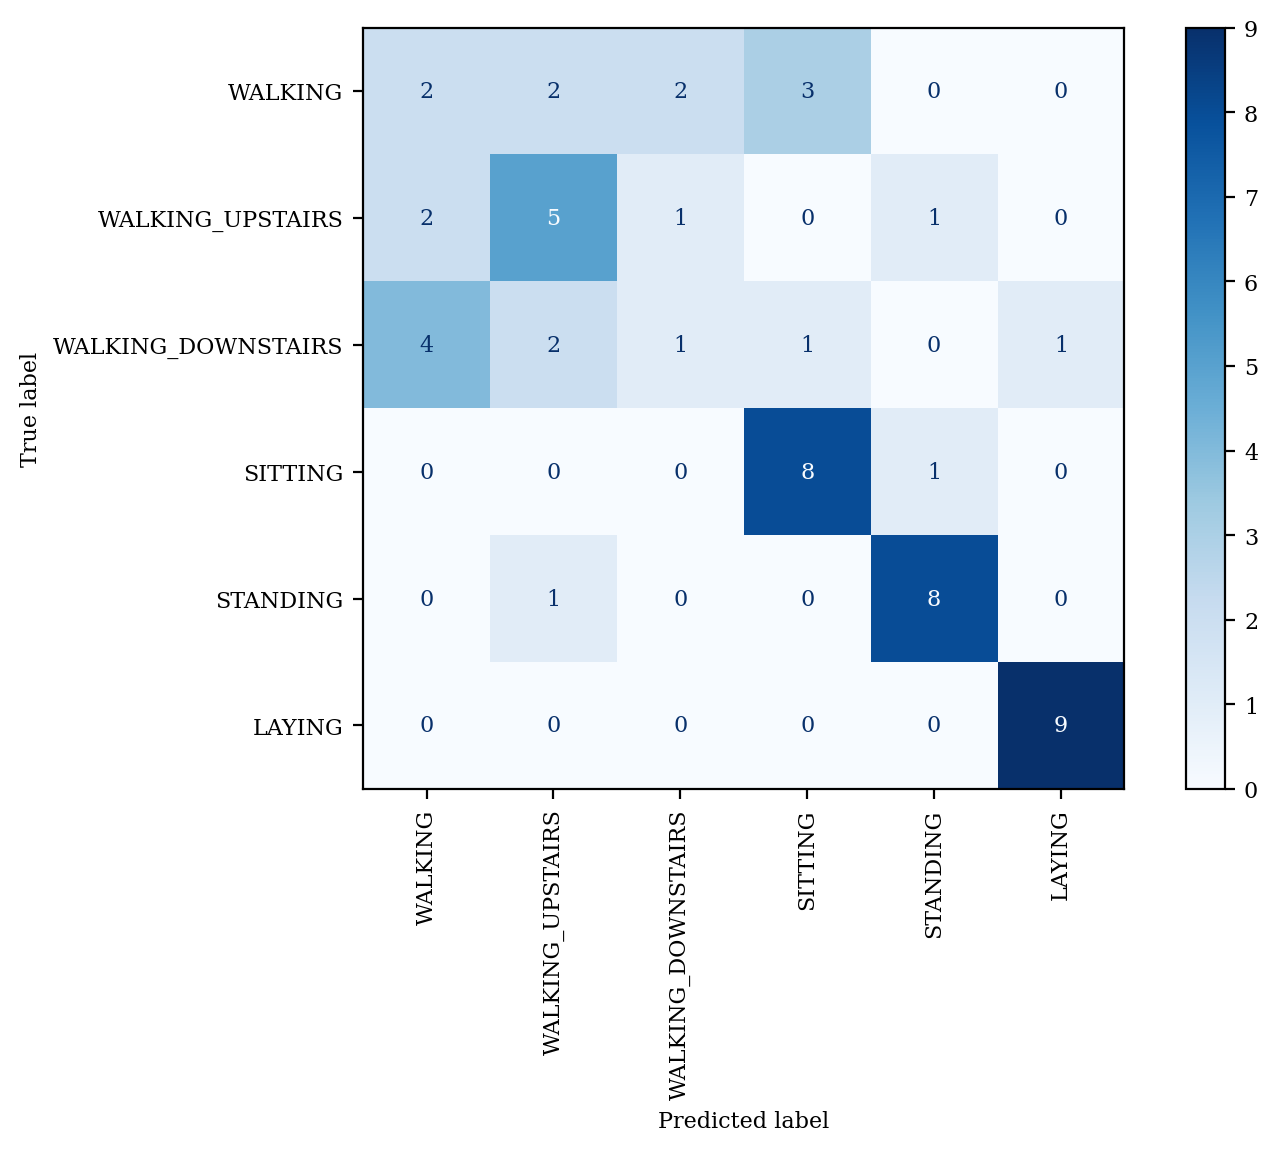

In [7]:
model_1 = DecisionTreeClassifier(random_state =42)
evaluate_model(model_1, X_train_flat, X_test_flat, y_train, y_test)

- #### Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

In [8]:
def obtain_features(X):
    # Initializing TSFEL feature configuration
    cfg = tsfel.get_features_by_domain() # Choosing all statistical, temporal and spectral features
    
    # List to hold DataFrames for all samples
    tsfel_features_list = []
    
    for sample in X:
        # Each sample is a time series with shape (500, 3)
        sample_features = tsfel.time_series_features_extractor(cfg, sample, verbose=0)
        tsfel_features_list.append(sample_features)
    
    # Concatenating all the individual sample feature DataFrames into one DataFrame
    tsfel_features_df = pd.concat(tsfel_features_list, axis=0, ignore_index=True)
    
    return tsfel_features_df


In [9]:
X_train_tsfel = obtain_features(X_train)
X_test_tsfel = obtain_features(X_test)

In [10]:
print("Shape of the training data after extracting all features using tsfel", X_train_tsfel.shape)
print("Shape of the testing data after extracting all features using tsfel", X_test_tsfel.shape)

Shape of the training data after extracting all features using tsfel (126, 1152)
Shape of the testing data after extracting all features using tsfel (54, 1152)


Accuracy: 0.89
Precision: 0.89
Recall: 0.89

Confusion Matrix:


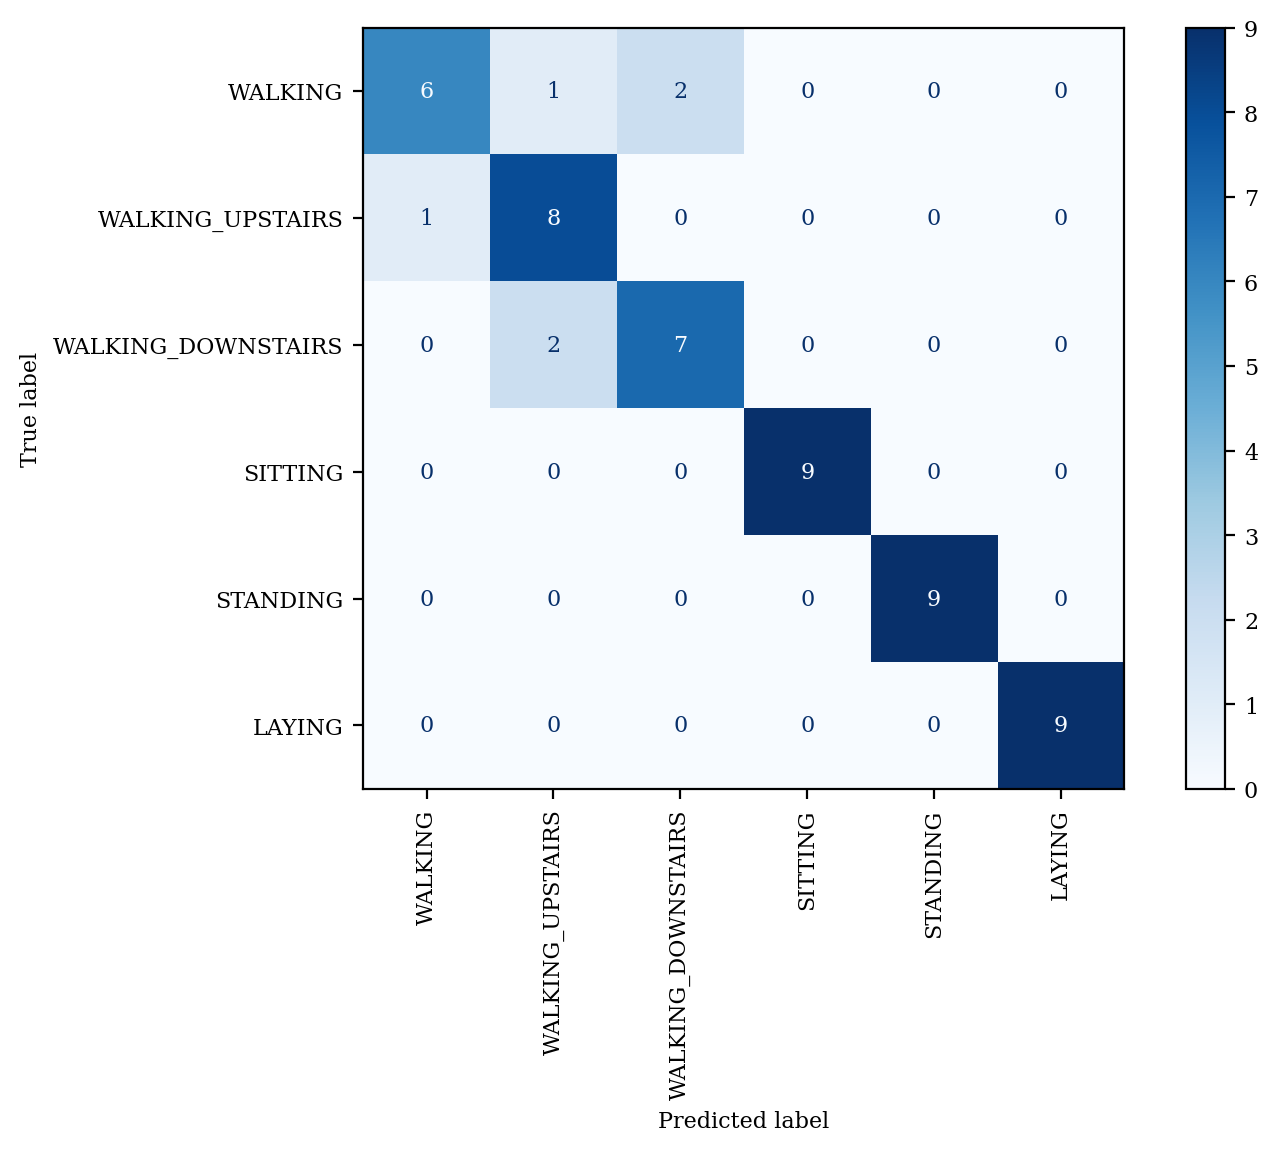

In [11]:
model_2 = DecisionTreeClassifier(random_state=42)
evaluate_model(model_2,X_train_tsfel, X_test_tsfel, y_train, y_test)

- #### Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.

In [12]:
# Loading the feature names
feature_names = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
feature_names_list = feature_names[1].tolist()

# Handling duplicate column names
feature_names_renamed = pd.Series(feature_names_list)
duplicates = feature_names_renamed[feature_names_renamed.duplicated()].unique()

for dup in duplicates:
    dup_indices = feature_names_renamed[feature_names_renamed == dup].index
    for i, idx in enumerate(dup_indices):
        feature_names_renamed[idx] = f"{dup}.{i+1}"

In [13]:
# Load the training and testing data using renamed feature names
X_train_data = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None, names=feature_names_renamed)
y_train_data = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['Activity'])

X_test_data = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None, names=feature_names_renamed)
y_test_data = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['Activity'])

In [14]:
print(f"X_train_data shape: {X_train_data.shape}")
print(f"y_train_data shape: {y_train_data.shape}")
print(f"X_test_data shape: {X_test_data.shape}")
print(f"y_test_data shape: {y_test_data.shape}")

X_train_data shape: (7352, 561)
y_train_data shape: (7352, 1)
X_test_data shape: (2947, 561)
y_test_data shape: (2947, 1)


Accuracy: 0.86
Precision: 0.86
Recall: 0.86

Confusion Matrix:


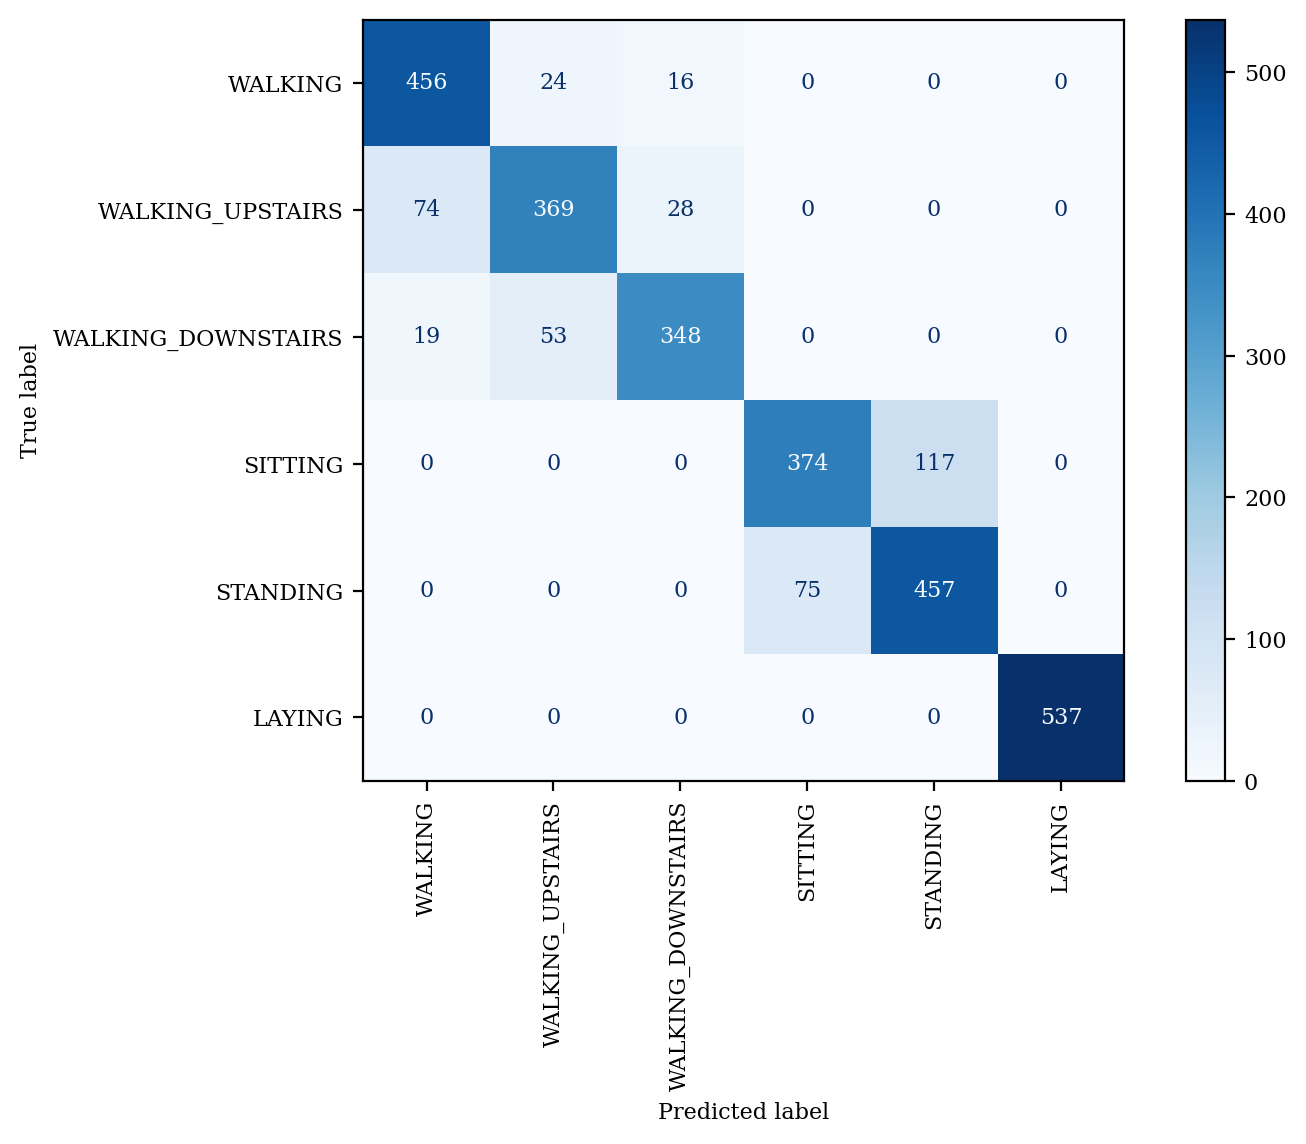

In [15]:
model_3 = DecisionTreeClassifier(random_state=42)
evaluate_model(model_3,X_train_data, X_test_data, y_train_data, y_test_data)

- ####  Compare the results of the three models. Which model do you think is better?
Comparison:<br>
The model_2 which had been fed by the features extracted using TSFEL performed the best among all models with an accuracy score of 89%.
TSFEL extracts relevant features designed to capture important patterns in time series data, which often results in improved performance over using raw or basic provided features. This is because TSFEL features are engineered to enhance the signal-to-noise ratio and improve classification accuracy.

# Question 2
#### Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]

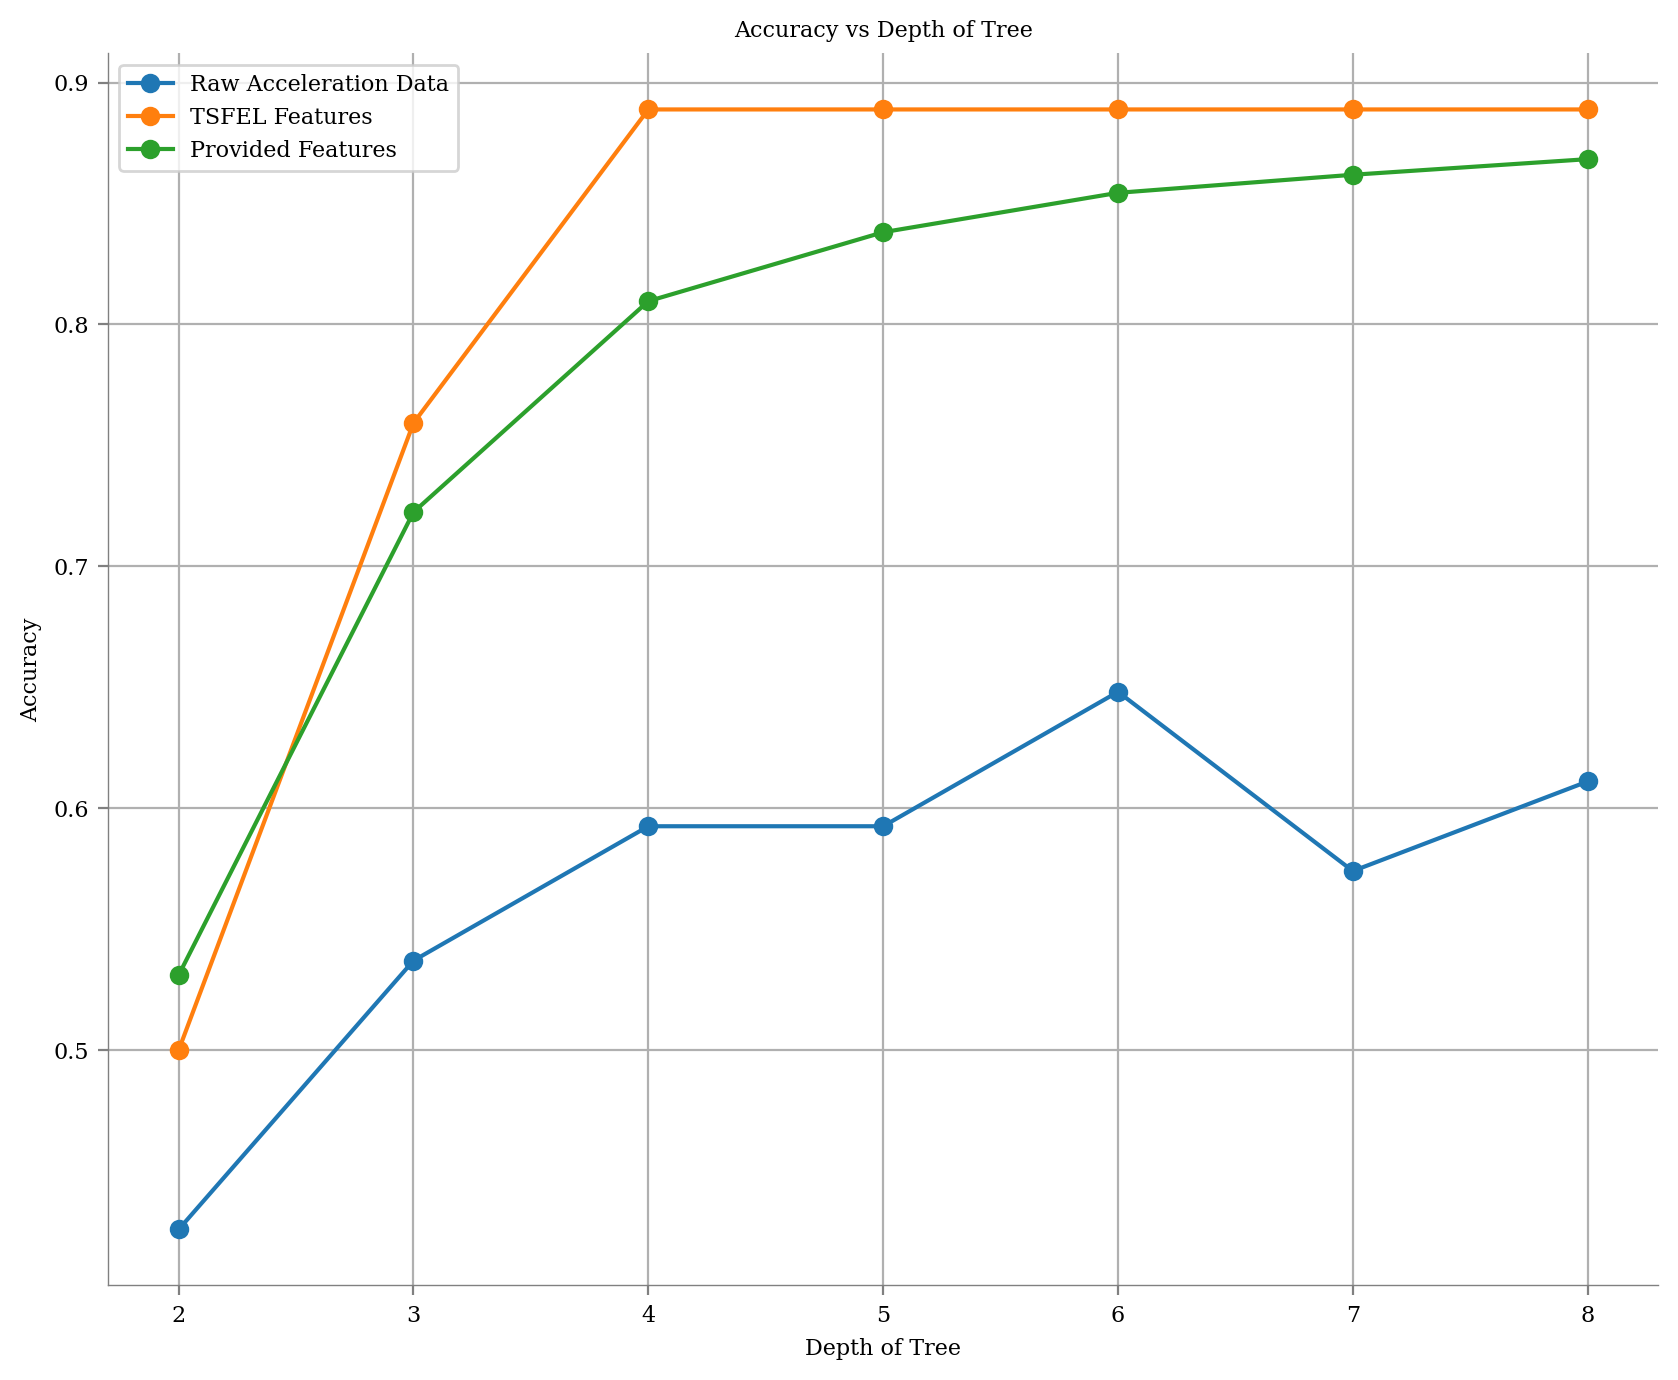

In [16]:
def evaluate_tree_depths(X_train, y_train, X_test, y_test, model_name):
    depths = range(2, 9)  
    accuracies = []

    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    plt.plot(depths, accuracies, marker='o', label=model_name)


latexify()
plt.figure(figsize=(10, 8))  
format_axes(plt.gca())

# Model 1: Raw acceleration data
evaluate_tree_depths(X_train_flat, y_train, X_test_flat, y_test, 'Raw Acceleration Data')

# Model 2: TSFEL features
evaluate_tree_depths(X_train_tsfel, y_train, X_test_tsfel, y_test, 'TSFEL Features')

# Model 3: Provided features
evaluate_tree_depths(X_train_data, y_train_data, X_test_data, y_test_data, 'Provided Features')

plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth of Tree')
plt.legend()
plt.grid(True)
plt.show()

# Question 3
#### Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?



For **model_2 (TSFEL Features)**, the performance is notably strong for static activities but less effective for dynamic activities. The confusion matrix indicates significant misclassification in dynamic activities, which can be attributed to their inherent variability and complexity. The features extracted by TSFEL may not fully capture the subtle differences between similar dynamic movements, leading to overlapping feature representations and difficulties in distinguishing between specific dynamic activities. 

Specifically in activities like Walking_Upstairs and Walking_downstairs the model's accuracy is slightly lesser and these activities are predicted to be Walking by the model. This happens as these activities are similar and have some subtle differences which can't be captured by accelerometer data.

Similarily, in static activities, sitting and standing are mixed sometimes showcasing the limited prediction capability of the model in case of similar activities.